In [141]:
import jax
import jax.numpy as jnp
import jax.tree_util as jtree

import numpy as np
import optax
import pandas as pd 
import matplotlib.pyplot as plt

from dln import (
    create_dln_model, 
    create_minibatches, 
    true_dln_learning_coefficient, 
    mse_loss, 
)
from sgld_utils import (
    SGLDConfig, 
    run_sgld
)
from utils import to_json_friendly_tree, running_mean



import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd
import seaborn as sns


def orthogonal_vector(v):
    v = jnp.asarray(v)
    
    # Find a vector that is not parallel to v
    if v[0] != 0:
        basis = jnp.array([1.0] + [0.0] * (v.shape[0] - 1))
    else:
        basis = jnp.array([0.0, 1.0] + [0.0] * (v.shape[0] - 2))
    
    # Compute the orthogonal vector using the cross product (in higher dimensions, Gram-Schmidt can be used)
    orthogonal_v = jnp.cross(v, basis) if v.shape[0] == 3 else gram_schmidt(v, basis)
    
    return orthogonal_v

def gram_schmidt(v, basis):
    # Project basis onto v and subtract to make it orthogonal
    projection = jnp.dot(basis, v) / jnp.dot(v, v) * v
    orthogonal_v = basis - projection
    return orthogonal_v

def make_orthogonal_row(matrix):
    matrix = jnp.asarray(matrix)
    orthogonal_rows = jnp.stack(
        [orthogonal_vector(matrix[i, :]) for i in range(matrix.shape[0])], 
        axis=0
    )
    return orthogonal_rows


In [197]:

expt_name = "dln_stagewise_learning"
do_llc_estimation = False
in_out_dim = 3
sgld_config = {
        'epsilon': 1e-6,
        'gamma': 1.0,
        'num_steps': 100,
        "num_chains": 1, 
        "batch_size": 128
    }
loss_trace_minibatch = True
width = in_out_dim
initialisation_exponent =  1.5
num_hidden_layers = 1
num_training_data = 10000
itemp = 1 / np.log(num_training_data)
training_config = {
    "optim": "sgd", 
    "learning_rate": 1e-4, 
    "momentum": None, 
    "batch_size": 128, 
    "num_steps": 20000
}
seed = 42
logging_period = 100 # 50
verbose = True

output_noise_std = 0.1

# seeding
np.random.seed(seed)
rngkey = jax.random.PRNGKey(seed)

####################
# Initialisations
####################
# Teacher matrix
initialisation_sigma = np.sqrt(width ** (-initialisation_exponent))
# teacher_matrix = 10.0 * np.diag(np.arange(in_out_dim) + 1)
# teacher_matrix = np.diag([30, 20, 10])
teacher_matrix = np.random.randn(in_out_dim, in_out_dim) * 10
np.fill_diagonal(teacher_matrix, 0.0)

input_dim = teacher_matrix.shape[0]
output_dim = teacher_matrix.shape[1]
layer_widths = [width] * num_hidden_layers + [output_dim]

# Training data from teacher matrix
rngkey, key = jax.random.split(rngkey)
x_train = jax.random.normal(key, shape=(num_training_data, input_dim))
rngkey, key = jax.random.split(rngkey)
y_train = x_train @ teacher_matrix + jax.random.normal(key, shape=(num_training_data, output_dim)) * output_noise_std

# DLN model
model = create_dln_model(layer_widths, sigma=initialisation_sigma)
loss_fn = jax.jit(lambda param, inputs, targets: mse_loss(param, model, inputs, targets))


rngkey, subkey = jax.random.split(rngkey)
init_param = model.init(rngkey, jnp.zeros((1, input_dim)))
w2 = init_param["deep_linear_network/linear"]["w"]
init_param["deep_linear_network/linear_1"]["w"] = make_orthogonal_row(w2).T
init_param = jtree.tree_map(lambda x: x * 10, init_param)
# init_param = jtree.tree_map(lambda x: jnp.array(
#     [[np.sqrt(10), 0., 0.], 
#      [0., np.sqrt(19), 0.], 
#      [0., 0.0, np.sqrt(9)]]), 
#     init_param
# )
# init_param = jtree.tree_map(lambda x: jnp.fill_diagonal(x, 0.0, inplace=False), init_param)
# init_param = {
#     'deep_linear_network/linear': {
#         'w': [
#             [ 0.        , -1.0194144 , -1.3859259 ],
#             [-0.16940922,  0.        , -0.56964767],
#             [ 0.4167226 , -0.46147144,  0.        ]
#         ]
#     },
#     'deep_linear_network/linear_1': {
#         'w': [
#             [ 0.        ,  1.6826538 ,  0.5695755 ],
#             [ 0.451281  ,  0.        , -0.00991823],
#             [-1.8046753 ,  1.0008276 ,  0.        ]
#         ]
#     }
# }
# init_param = jtree.tree_map(lambda x: jnp.asarray(x), init_param)


print("Model initialised with shapes:")
jtree.tree_map(lambda x: print(x.shape), init_param)


def h_ij(param, mat_input_output_covariance, mat_u=None, mat_v=None):
    w_tot = jnp.linalg.multi_dot(
        [
            jnp.array(param[f'deep_linear_network/linear{loc}']['w']) 
            for loc in [''] + [f'_{i}' for i in range(1, len(layer_widths))]
        ]
    )
    if mat_u is None:
        mat_u = jnp.eye(w_tot.shape[0])
        # mat_u, _, mat_v = jnp.linalg.svd(w_tot)
    if mat_v is None:
        mat_v = jnp.eye(w_tot.shape[1])
        # _, _, mat_v = jnp.linalg.svd(w_tot)

    return mat_u.T @ (w_tot - mat_input_output_covariance) @ mat_v
##############################################
# Train the model and do SGLD at some interval
##############################################

sgld_config = SGLDConfig(**sgld_config)

optimizer = optax.sgd(learning_rate=training_config["learning_rate"])
max_steps = training_config["num_steps"]
t = 0
rngkey, subkey = jax.random.split(rngkey)
grad_fn = jax.jit(jax.value_and_grad(loss_fn, argnums=0))
trained_param = init_param
opt_state = optimizer.init(trained_param)

input_output_covariance = teacher_matrix
mat_u = jnp.eye(input_output_covariance.shape[0])
mat_v = jnp.eye(input_output_covariance.shape[1])


info = []
while t < max_steps:
    for x_batch, y_batch in create_minibatches(x_train, y_train, batch_size=training_config["batch_size"]):
        train_loss, grads = grad_fn(trained_param, x_batch, y_batch)
        updates, opt_state = optimizer.update(grads, opt_state)
        trained_param = optax.apply_updates(trained_param, updates)
        
        if t % logging_period == 0: 
            potential_matrix  = h_ij(trained_param, input_output_covariance, mat_u=mat_u, mat_v=mat_v)
                
            rec = {
                "t": t + 1, 
                "train_loss": float(train_loss),
                "trained_param": trained_param,
                "potential_matrix": potential_matrix,
            }
            
            if do_llc_estimation:
                rngkey, subkey = jax.random.split(rngkey)
                y_realisable = model.apply(trained_param, x_train) #+ jax.random.normal(subkey, shape=(num_training_data, output_dim)) * output_noise_std
                y = y_realisable
                # y = y_train

                rngkey, subkey = jax.random.split(rngkey)
                loss_trace, distances, acceptance_probs = run_sgld(
                    subkey, 
                    loss_fn, 
                    sgld_config, 
                    trained_param, 
                    x_train, 
                    y,
                    itemp=itemp, 
                    trace_batch_loss=loss_trace_minibatch, 
                    compute_distance=False, 
                    verbose=False, 
                    compute_mala_acceptance=False
                )
                
                init_loss = loss_fn(trained_param, x_train, y)
                lambdahat = float(np.mean(loss_trace) - init_loss) * num_training_data * itemp

                true_matrix = jnp.linalg.multi_dot(
                    [trained_param[f'deep_linear_network/linear{loc}']['w'] for loc in [''] + [f'_{i}' for i in range(1, len(layer_widths))]]
                )
                true_rank = jnp.linalg.matrix_rank(true_matrix)
                true_lambda, true_multiplicity = true_dln_learning_coefficient(
                    true_rank, 
                    layer_widths, 
                    input_dim, 
                )
            
                rec.update(
                    {
                        "lambdahat": float(lambdahat),
                        "true_lambda": true_lambda, 
                        "true_multiplicity": true_multiplicity, 
                        "loss_trace": loss_trace, 
                        "true_rank": true_rank,
                        "init_loss": float(init_loss),
                    }
                )
            if verbose and t % 1000 == 0:
                print(
                    f"t: {t + 1}, "
                    + f"train_loss: {float(train_loss):.4f}, "
                    + (f"lambdahat: {lambdahat:.4f}, " if do_llc_estimation else "")
                )

            info.append(to_json_friendly_tree(rec))
        
        t += 1
        if t >= max_steps:
            break


Model initialised with shapes:
(3, 3)
(3, 3)
t: 1, train_loss: 224.2738, 
t: 1001, train_loss: 28.6497, 
t: 2001, train_loss: 21.3105, 
t: 3001, train_loss: 11.7657, 
t: 4001, train_loss: 5.8648, 
t: 5001, train_loss: 2.3991, 
t: 6001, train_loss: 1.1966, 
t: 7001, train_loss: 0.5001, 
t: 8001, train_loss: 0.2468, 
t: 9001, train_loss: 0.0920, 
t: 10001, train_loss: 0.0573, 
t: 11001, train_loss: 0.0278, 
t: 12001, train_loss: 0.0190, 
t: 13001, train_loss: 0.0129, 
t: 14001, train_loss: 0.0113, 
t: 15001, train_loss: 0.0101, 
t: 16001, train_loss: 0.0097, 
t: 17001, train_loss: 0.0107, 
t: 18001, train_loss: 0.0098, 
t: 19001, train_loss: 0.0104, 


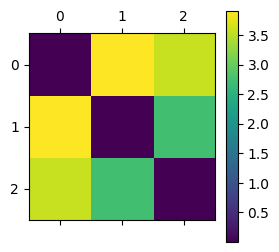

In [198]:
init_prod_mat = jnp.linalg.multi_dot(
    [
        jnp.array(init_param[f'deep_linear_network/linear{loc}']['w']) 
            for loc in [''] + [f'_{i}' for i in range(1, len(layer_widths))]
    ]
)
fig, ax = plt.subplots(figsize=(3, 3))
cax = ax.matshow(np.abs(init_prod_mat), cmap='viridis')
fig.colorbar(cax)


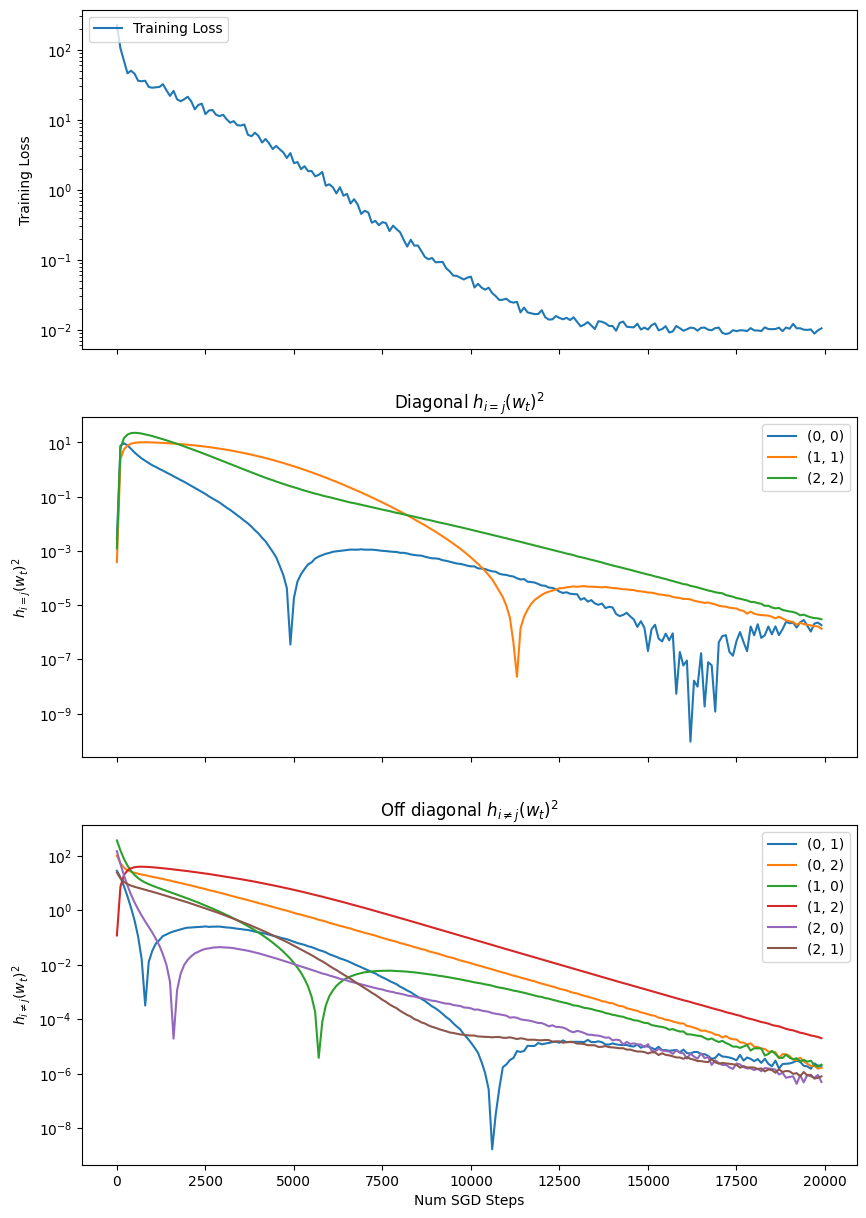

In [202]:
df = pd.DataFrame(info)
fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
ax = axes[0]
ax.plot(df["t"], df["train_loss"], label="Training Loss")
ax.set_ylabel("Training Loss")
ax.legend(loc="upper left")


if do_llc_estimation:
    ax = ax.twinx()
    ax.plot(df["t"], np.clip(df["lambdahat"], a_min=0, a_max=np.inf), "kx", alpha=0.3, label="Estimated LLC, $\hat{\lambda}(w^*)$")
    yvals = running_mean(df["lambdahat"])
    ax.plot(df["t"], yvals, "g-")
    ax.set_ylabel("Estimated LLC, $\hat{\lambda}(w^*)$")
    ax.legend(loc="upper right")


ax = axes[1]
for i in range(input_output_covariance.shape[0]):
    yvals = df["potential_matrix"].apply(lambda x: np.array(x)[i, i]**2)
    ax.plot(df["t"], yvals, label=f"({i}, {i})")
ax.set_ylabel("$h_{i=j}(w_t)^2$")
ax.set_title("Diagonal $h_{i=j}(w_t)^2$")
ax.legend()

ax = axes[2]
for i in range(input_output_covariance.shape[0]):
    for j in range(input_output_covariance.shape[1]):
        if i == j: continue # only plot the off diagonal elements
        yvals = df["potential_matrix"].apply(lambda x: np.array(x)[i, j]**2)
        ax.plot(df["t"], yvals, label=f"({i}, {j})")
ax.set_ylabel("$h_{i \\neq j}(w_t)^2$")
ax.set_title("Off diagonal $h_{i \\neq j}(w_t)^2$")
ax.legend()


for i, ax in enumerate(axes): 
    if i == len(axes) - 1:
        ax.set_xlabel("Num SGD Steps")
    ax.set_yscale("log")


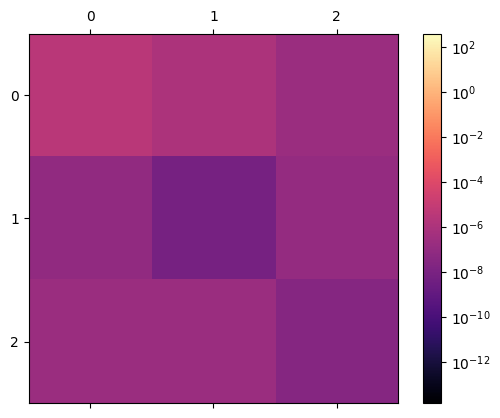

In [108]:
from matplotlib.colors import LogNorm

h_ij_sqvals = [x**2 for x in df["potential_matrix"].to_list()][::3]
# Create a figure and axis
fig, ax = plt.subplots()
norm = LogNorm()
cax = ax.matshow(h_ij_sqvals[0], cmap='magma', norm=norm)
cbar = fig.colorbar(cax)

# Function to update the heatmap
def update(frame):
    cax.set_array(h_ij_sqvals[frame])
    return cax,

# Create an animation
ani = animation.FuncAnimation(fig, update, frames=len(h_ij_sqvals), blit=True)

HTML(ani.to_jshtml())
# ani.save("dln_stagewise_learning.gif", writer="imagemagick", fps=10)
# ! open dln_stagewise_learning.gif